# Spatial Statistics with Python (BigDIPA 2017)

**A tutorial using Python to calculate spatial statistics.**

By [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)<br/>
Department of Computer Science
University of California, Irvine

September 20, 2017

## Outline
-------------------------
Point processes are quite general models of points in space and/or time and are useful for analyzing a range of observed phenomenom.  In this lab, we study three types of processes: homogeneous and non- Poisson Processes, clustering processes, and repellant processes.  We also cover how to compute so-called G-statistics for a point process in order to test if the points are homogeneous, clustered, or repellant.   

The lab consists of two parts:
### Part 1
- Define Poisson process and simulate data from one.
- Define clustering and repellant processes as extensions of a Poisson process.  
- Plot data from covered processes.

### Part 2
- Define and calculate the G statistic.
- Implement replication to gague uncertainty.


## References
----------------------------------
[Analysing spatial point patterns in R](http://www2.stat.unibo.it/bruno/dati%20spaziali%200809/spatialpointpatterns.pdf) : Description and implementation in R of the discussed methods. 

## Import Packages
-----------------------------

In [218]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#  PART 1:  Point Process Models
--------------------

For a product space $\mathcal{X} \times \mathcal{Y}$, define a Poisson process over the space as:

$$n \sim Poisson(\lambda_{0} \mid \mathcal{X} \times \mathcal{Y} \mid)$$ 

$$u_{i} \sim Uniform(\mathcal{X} \times \mathcal{Y}) \ \ \ for \ \ i \in [1, n]$$

where $\mid \mathcal{X} \times \mathcal{Y} \mid$ denotes the volume of the space.  Notice here that the Poisson intensity paramter, $\lambda_{0}$, is fixed across the space.  Thus we call the process **homogeneous**.  If $\lambda = f(x,y)$, rather, varies, we call the process **non-homogeneous**.  Next we'll implement a function that can sample from both types of processes.      

## 1.1  Sample from Poisson Process

In [137]:
# 10 X 10 
nX = 10
nY = nX

# Generate the same data by setting the seed
seed(135)

def sample_from_poisson_process(intensity=1., nonhomog_fn=None, area_min=0., area_max=nX, step_size=1.):
    
    ### Homogeneous process
    if nonhomog_fn is None:
        # draw uniformly over the area
        n = np.random.poisson(intensity * (area_max-area_min)**2)
        return np.random.uniform(low=area_min, high=area_max, size=(n,2))
    
    ### Non-Homogenous process defined by nonhomog_fn(x, y, step_size)
    # for simplicity, we'll simulate from a patch work of homogenous PPs
    else:
        sample_aggregator = []
        for y in np.arange(area_min, area_max, step_size):
            for x in np.arange(area_min, area_max, step_size):
                
                samples = sample_from_poisson_process(nonhomog_fn(x, y, step_size), area_min=0., area_max=step_size)
                samples[:,0] = samples[:,0] + x
                samples[:,1] = samples[:,1] + y
                sample_aggregator.append(samples)
                
        return np.vstack(sample_aggregator)    

## 1.2  Plot Non- and Homogeneous Processes

First, let's define a function for the non-homogenous process.

In [219]:
def intensity_fn(x, y, step_size):
    if x == y:
        return 25.
    else:
        return 1.

Simulate data from both types of Poisson processes.

In [220]:
x_homog_pp = sample_from_poisson_process(intensity=5.)
x_nonhomog_pp = sample_from_poisson_process(nonhomog_fn=intensity_fn)

Plot the two processes.

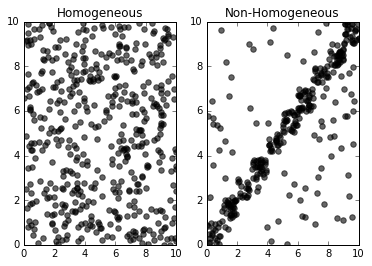

In [221]:
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(x_homog_pp[:,0], x_homog_pp[:,1], s=30, color='black', alpha=0.6)
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(x_nonhomog_pp[:,0], x_nonhomog_pp[:,1], s=30, color='black', alpha=0.6)
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.title("Non-Homogeneous")

plt.show()

## 1.3  Poisson Cluster Process

Notice that the Poisson Process---both types---samples points independently.  Even in the non-homogeneous type, the intensity depends on location in space, and the points are conditionally independent, given the location.  Next we look at point processes with inter-point dependence.  Define a *Poisson cluster process*, with parameters $\lambda_{0}$ and $\sigma_{0}$, as follows: 

$$ \{ u_{i} \} \sim Poisson \ Process(\lambda_{0}) $$
$$ n_{i} \sim Poisson(\lambda_{i}) $$
$$ \{ u_{i,j} \} \sim \text{Normal}(\mu=u_{i}, \sigma_{0}) \ \ \ for \ \ j \in [1, n_{i}]$$

The final sample set consists of both the parent and child points: $ \{ \{ u_{i} \}, \{ u_{i,j} \} \} $.  Let's define the child generator...

In [222]:
def sample_child_point(x0, cluster_intensity=1.):
    n = np.random.poisson(cluster_intensity)
    if n < 1: return None
    
    samples = []
    while len(samples) < n:
        s = np.random.normal(scale=.1, size=(1,2))
        samples.append( x0 + s )
    
    return np.vstack(samples)

Now let's use the child generator to sample a full cluster process...

In [224]:
### Sample parent points from Poisson process
x_homog_pp = sample_from_poisson_process(intensity=.4)

### Sample child points
candidates = [sample_child_point(x_homog_pp[i]) for i in range(x_homog_pp.shape[0])]
x_child_points = np.vstack([x for x in candidates if x is not None])

### Combine for final sample set
cluster_process = np.vstack([x_homog_pp, x_child_points])

Plot the parent and child points separately...

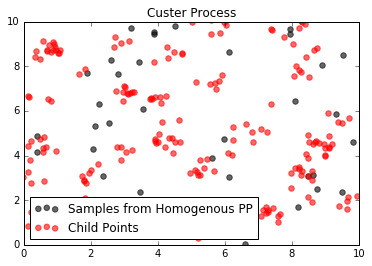

In [225]:
plt.figure()

plt.scatter(x_homog_pp[:,0], x_homog_pp[:,1], s=30, color='black', alpha=0.6, label="Samples from Homogenous PP")
plt.scatter(x_cluster_process[:,0], x_cluster_process[:,1], s=30, color='red', alpha=0.6, label="Child Points")

plt.xlim([0,nX])
plt.ylim([0,nX])
plt.legend(loc=3)
plt.title("Custer Process")

plt.show()

## 1.4  Thinning Process

For our final point process, consider the **Matern Model**.  Similarly to the cluster process, we'll sample from a homogeneous Poisson process and then perform a second-step based the parent points.  This time, we'll simply remove points that occur within a distance $r$ of one another.  Define *Matern($\lambda_{0}$, $r$)* as... 

$$ \{ u_{i} \} \sim Poisson \ Process(\lambda_{0}) $$
$$ \textbf{remove} \ \  u_{i} \ \ if  \ \ \mid \mid u_{i} - u_{j} \mid \mid_{2} \ \ for \ any \ \ j < i$$

Now let's define the thinning method...

In [226]:
def thin_process(data, radius=1.):
    X = np.array(data)
    
    test_idx = X.shape[0]-1
    while test_idx > 0:
        for idx in range(test_idx):
            
            if np.sqrt(np.sum((X[test_idx] - X[idx])**2)) <= radius:
                X = np.delete(X, test_idx, 0)
                break
                
        test_idx -= 1
    return X

Let's sample from the process...

In [227]:
x_homog_pp = sample_from_poisson_process(intensity=.4)
thinned_process = thin_process(x_homog_pp)

Plot the original and final points...

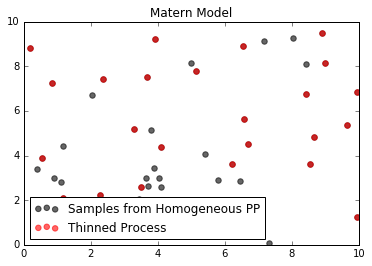

In [228]:
plt.figure()
plt.scatter(x_homog_pp[:,0], x_homog_pp[:,1], s=30, color='black', alpha=0.6, label="Samples from Homogeneous PP")
plt.scatter(thinned_process[:,0], thinned_process[:,1], s=30, color='red', alpha=0.6, label="Thinned Process")
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.legend(loc=3)
plt.title("Matern Model")

plt.show()

# PART 2:  Testing Observed Data
--------------------

Having defined the above processes, now let's consider the scenario in which we have observed data and want to test if it originated from a poisson process, a clustering process, or a repellant process.  To do this, we'll use the **G function** (see *Baddeley 15.3.1*):

$$ G(\mathbf{X}, r) = \frac{1}{N_{X}} \sum_{i=1}^{N_{X}} \mathbb{1}[ t_{i} \le r ] $$

where $r$ is a parameter and $t_{i} = \min \mid \mid u_{i} - u_{j} \mid \mid_{2}$.  Or in words, $t_{i}$ is the distance from $u_{i}$ to its nearest neighbor.

Let's implement the G function...

In [229]:
def calculate_emp_G_statistic(data, radius=1.):
    
    n = data.shape[0]
    dist_tests = [0.] * n
    
    for i in range(n):
        for j in range(n):
            
            if i == j or dist_tests[j] == 1: continue
            
            euc_dist = np.sqrt(np.sum((data[i] - data[j])**2))
            if euc_dist <= radius:
                dist_tests[i] = 1.
                dist_tests[j] = 1.
                break
                
    return np.sum(dist_tests)/n

It's the data is from a Poisson process, the G statistic has an asymptotic form, given as follows 

$$ G_{poisson}(\lambda, r) = 1 - e^{-\lambda \pi r^{2}} .$$ 

We can use this formula for observed data if we use an empirical estimate for the intensity:

$$ \hat{\lambda} = \mid \mathbf{X} \mid / \mid \mathcal{X} \times \mathcal{Y} \mid $$ where $\mid \mathbf{X} \mid$ is the number of observations and $\mid \mathcal{X} \times \mathcal{Y} \mid$ is the volume of the space.

In [230]:
def calculate_emp_intensity(data):
    return data.shape[0]/(np.max(data)-np.min(data))**2


def calculate_poisson_G_statistic(data, radius=1.):
    
    emp_intensity = calculate_emp_intensity(data)        
    return 1 - np.exp(-emp_intensity * np.pi * radius**2)

Now let's calculate the empirical and asympotic G statistics for a range of $r$ values...

In [231]:
radi = np.arange(.01, 2., .1)

data = x_homog_pp
g_stats_homog = [calculate_G_statistic(data, radius=r) for r in radi]
g_poisson_homog = [calculate_poisson_G_statistic(data, radius=r) for r in radi]

data = thinned_process
g_stats_thinned = [calculate_G_statistic(data, radius=r) for r in radi]
g_poisson_thinned = [calculate_poisson_G_statistic(data, radius=r) for r in radi]

data = cluster_process
g_stats_clustered = [calculate_G_statistic(data, radius=r) for r in radi]
g_poisson_clustered = [calculate_poisson_G_statistic(data, radius=r) for r in radi]

Plot the curves for each point process type...

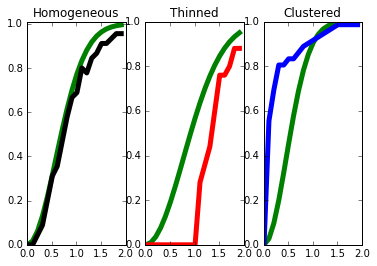

In [232]:
### Make Plots
ax1 = plt.subplot(1, 3, 1)
ax1.plot(radi, g_poisson_homog,'g-', linewidth=5.)
ax1.plot(radi, g_stats_homog,'k-', linewidth=5.)
plt.xlim([0,2.])
plt.ylim([0,1.01])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 3, 2)
ax2.plot(radi, g_poisson_thinned,'g-', linewidth=5.)
ax2.plot(radi, g_stats_thinned,'r-', linewidth=5.)
plt.xlim([0,2.])
plt.ylim([0,1.])
plt.title("Thinned")

ax3 = plt.subplot(1, 3, 3)
ax3.plot(radi, g_poisson_clustered,'g-', linewidth=5.)
ax3.plot(radi, g_stats_clustered,'b-', linewidth=5.)
plt.xlim([0,2.])
plt.ylim([0,1.])
plt.title("Clustered")

plt.show()

## 2.1  Uncertainty Estimation

We have only a finite set of observations and thus need to take uncertainty into account when we perform our tests.  To do this, we'll simulate many dataset resamplings...

In [234]:
### Define Number of replications
n_replications = 1000

Calculate the G-Poisson stat under replication...

In [235]:
### Calc G stats for what we know is a homogeneous process
data = x_homog_pp

g_stats_homog = [calculate_G_statistic(data, radius=r) for r in radi]

# Calculate G stat under repeated sampling from PP with emp intensity
emp_intensity = calculate_emp_intensity(data)
g_poisson_homog = []
for i in range(n_replications):
    g_poisson_homog.append([calculate_poisson_G_statistic(sample_from_poisson_process(intensity=emp_intensity), radius=r) for r in radi])

# Compute mean and std of replications    
g_poisson_homog_mean = np.mean(np.array(g_poisson_homog), axis=0)
g_poisson_homog_std = np.std(np.array(g_poisson_homog), axis=0)


### Calc G stats for what we know is a thinned process
data = thinned_process
g_stats_thinned = [calculate_G_statistic(data, radius=r) for r in radi]

# Calculate G stat under repeated sampling from PP with emp intensity
emp_intensity = calculate_emp_intensity(data)
g_poisson_thinned = []
for i in range(n_replications):
    g_poisson_thinned.append([calculate_poisson_G_statistic(sample_from_poisson_process(intensity=emp_intensity), radius=r) for r in radi])

# Compute mean and std of replications    
g_poisson_thinned_mean = np.mean(np.array(g_poisson_thinned), axis=0)
g_poisson_thinned_std = np.std(np.array(g_poisson_thinned), axis=0)
    
    
### Calc G stats for what we know is a clustered process
data = cluster_process
g_stats_clustered = [calculate_G_statistic(data, radius=r) for r in radi]

# Calculate G stat under repeated sampling from PP with emp intensity
emp_intensity = calculate_emp_intensity(data)
g_poisson_clustered = []
for i in range(n_replications):
    g_poisson_clustered.append([calculate_poisson_G_statistic(sample_from_poisson_process(intensity=emp_intensity), radius=r) for r in radi])

# Compute mean and std of replications
g_poisson_clustered_mean = np.mean(np.array(g_poisson_clustered), axis=0)
g_poisson_clustered_std = np.std(np.array(g_poisson_clustered), axis=0)

Plot the results...

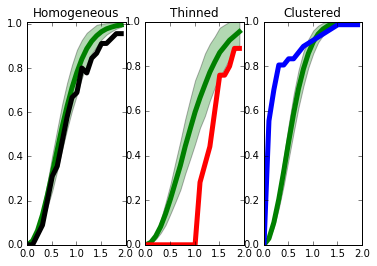

In [237]:
### Make Plots
ax1 = plt.subplot(1, 3, 1)
ax1.fill_between(radi, g_poisson_homog_mean-2*g_poisson_homog_std, g_poisson_homog_mean+2*g_poisson_homog_std, facecolor='green', interpolate=True, alpha=.3)
ax1.plot(radi, g_poisson_homog_mean,'g-', linewidth=5.)
ax1.plot(radi, g_stats_homog,'k-', linewidth=5.)
plt.xlim([0,2.])
plt.ylim([0,1.01])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 3, 2)
ax2.fill_between(radi, g_poisson_thinned_mean-2*g_poisson_thinned_std, g_poisson_thinned_mean+2*g_poisson_thinned_std, facecolor='green', interpolate=True, alpha=.3)
ax2.plot(radi, g_poisson_thinned_mean,'g-', linewidth=5.)
ax2.plot(radi, g_stats_thinned,'r-', linewidth=5.)
plt.xlim([0,2.])
plt.ylim([0,1.])
plt.title("Thinned")

ax3 = plt.subplot(1, 3, 3)
ax3.fill_between(radi, g_poisson_clustered_mean-2*g_poisson_clustered_std, g_poisson_clustered_mean+2*g_poisson_clustered_std, facecolor='green', interpolate=True, alpha=.3)
ax3.plot(radi, g_poisson_clustered_mean,'g-', linewidth=5.)
ax3.plot(radi, g_stats_clustered,'b-', linewidth=5.)
plt.xlim([0,2.])
plt.ylim([0,1.])
plt.title("Clustered")

plt.show()